# 1. Libraries


In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xgboost as xgb

from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV


# 2. Loading dataset and EDA

In [14]:
data = pd.read_csv('../data/clean_hcmc_waq.csv', delimiter=",")
data.head()

,date_time,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,cloud_cover,vapour_pressure_deficit,wind_speed_10m,wind_direction_10m,pm10,pm2_5,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide,ozone,us_aqi,weather_status
0,2022-10-01 07:00:00,25.511000,94.49476,24.561,31.543438,1.3,44.700000,0.179606,2.902413,209.74480,61.2,42.1,1123.0,50.80,11.50,4.0,73.652490,Light Rain
1,2022-10-01 08:00:00,26.411001,88.26100,24.311,31.320229,0.6,55.500000,0.403905,9.504272,232.69597,36.9,24.9,906.0,43.05,11.25,14.0,76.471634,Moderate Drizzle
2,2022-10-01 09:00:00,26.911001,88.03870,24.761,32.211530,0.7,46.200005,0.423807,8.788720,214.99210,28.0,18.5,598.0,31.95,10.90,27.0,77.597520,Moderate Drizzle
3,2022-10-01 10:00:00,28.011000,85.29904,25.311,33.920822,0.6,100.000000,0.555415,7.072878,194.74360,24.2,15.9,281.0,19.70,10.50,48.0,78.182625,Moderate Drizzle
4,2022-10-01 11:00:00,29.011000,78.12226,24.811,34.491055,0.4,100.000000,0.875935,7.754637,201.80147,26.0,17.1,213.0,14.25,10.50,67.0,78.430855,Light Drizzle


In [15]:
data.keys()

Index(['date_time', 'temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
       'apparent_temperature', 'precipitation', 'cloud_cover',
       'vapour_pressure_deficit', 'wind_speed_10m', 'wind_direction_10m',
       'pm10', 'pm2_5', 'carbon_monoxide', 'nitrogen_dioxide',
       'sulphur_dioxide', 'ozone', 'us_aqi', 'weather_status'],
      dtype='object')

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17544 entries, 0 to 17543
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date_time                17544 non-null  object 
 1   temperature_2m           17544 non-null  float64
 2   relative_humidity_2m     17544 non-null  float64
 3   dew_point_2m             17544 non-null  float64
 4   apparent_temperature     17544 non-null  float64
 5   precipitation            17544 non-null  float64
 6   cloud_cover              17544 non-null  float64
 7   vapour_pressure_deficit  17544 non-null  float64
 8   wind_speed_10m           17544 non-null  float64
 9   wind_direction_10m       17544 non-null  float64
 10  pm10                     17544 non-null  float64
 11  pm2_5                    17544 non-null  float64
 12  carbon_monoxide          17544 non-null  float64
 13  nitrogen_dioxide         17544 non-null  float64
 14  sulphur_dioxide       

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Light Rain'),
  Text(1, 0, 'Moderate Drizzle'),
  Text(2, 0, 'Light Drizzle'),
  Text(3, 0, 'Moderate Rain'),
  Text(4, 0, 'Overcast'),
  Text(5, 0, 'Heavy Rain'),
  Text(6, 0, 'Dense Drizzle'),
  Text(7, 0, 'Partly Cloudy'),
  Text(8, 0, 'Mainly Clear'),
  Text(9, 0, 'Clear Sky')])

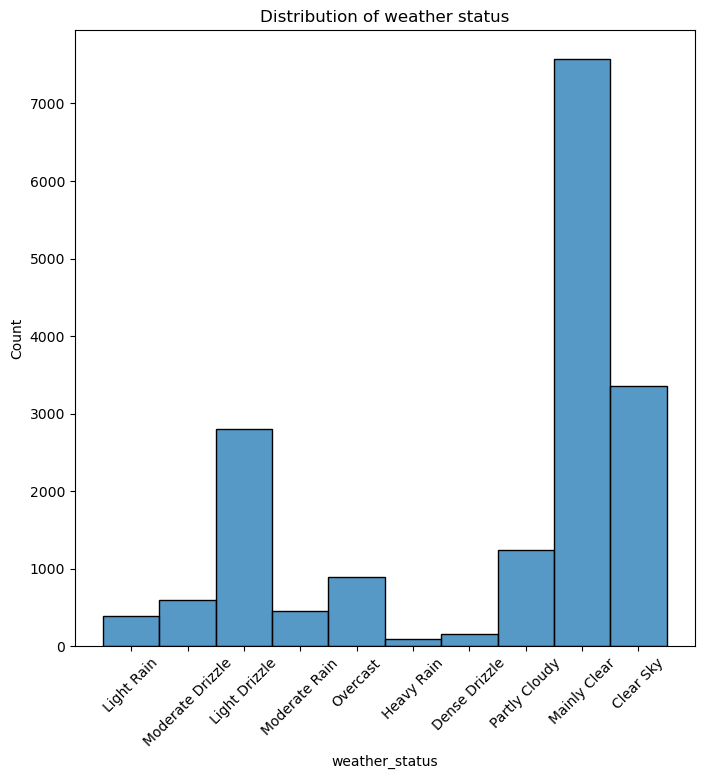

In [17]:
plt.figure(figsize=(8, 8))
sns.histplot(data['weather_status'])
plt.title('Distribution of weather status')
plt.xticks(rotation=45)

# 3. Preprocessing dataset

In [18]:
data['date_time'] = pd.to_datetime(data['date_time'])
data.set_index('date_time', inplace=True)
data = data.sort_index()

In [22]:

# Tạo các feature giải thích (exogenous variables)
exog_features = data[['temperature_2m', 'relative_humidity_2m', 'wind_speed_10m']]  # Thêm các feature cần thiết vào đây

# Target variable
target = data['us_aqi']

# Train-test split
train_size = int(len(target) * 0.8)
train, test = target[:train_size], target[train_size:]
exog_train, exog_test = exog_features[:train_size], exog_features[train_size:]

# Fit ARIMAX model (ARIMA with exogenous variables)
model = ARIMA(train, exog=exog_train, order=(1, 1, 1))  # (p, d, q) cần tùy chỉnh
arimax_model = model.fit()

# Dự báo với các biến giải thích từ tập kiểm tra
forecast = arimax_model.forecast(steps=len(test), exog=exog_test)

# Đánh giá mô hình
mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
print(f'MAE: {mae}, MSE: {mse}')


/home/van/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/van/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/van/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


MAE: 18.320959518614536, MSE: 531.1428166168454


In [ ]:
target = data['us_aqi']

train_size = int(len(target) * 0.8)
train, test = target[:train_size], target[train_size:]

# Fit ARIMA model
model1 = ARIMA(train, order=(1, 1, 1))
arima_model1 = model1.fit()
forecast = arima_model1.forecast(steps=len(test))

mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
print(f'MAE: {mae}, MSE: {mse}')

/home/van/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/van/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/van/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


MAE: 18.33404655175873, MSE: 531.8400473972619


In [32]:

# Extract datetime features (year, month, day, hour, etc.)
data['year'] = data.index.year
data['month'] = data.index.month
data['day'] = data.index.day
data['day_of_week'] = data.index.dayofweek
data['hour'] = data.index.hour
data['minute'] = data.index.minute

# Select features (X) and target (y)
features = ['temperature_2m', 'relative_humidity_2m', 'dew_point_2m', 
            'apparent_temperature', 'precipitation', 'cloud_cover', 
            'vapour_pressure_deficit', 'wind_speed_10m', 'wind_direction_10m',
            'pm10', 'pm2_5', 'carbon_monoxide', 'nitrogen_dioxide', 
            'sulphur_dioxide', 'ozone', 'year', 'month', 'day', 'day_of_week', 'hour', 'minute']
target = 'us_aqi'

X = data[features]  # Features
y = data[target]    # Target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Initialize and train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'R2 Score: {r2}')

MAE: 12.037120979193503
MSE: 240.8376793587186
R2 Score: 0.026368860761532997


In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [1, 4]
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

print(f'Best parameters: {grid_search.best_params_}')

In [ ]:

X = data[features]  # Features
y = data[target]    # Target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Initialize and train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'R2 Score: {r2}')

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=XGBRegressor(random_state=42), param_grid=param_grid, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print(f'Best parameters: {grid_search.best_params_}')